In [6]:
import numpy as np
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
import sys
sys.path.append(os.path.abspath('..')) 
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from typing import Tuple, Optional, List
from deepkoop_func import koopman_loss, prediction_loss, get_device
from tqdm.notebook import tqdm  # progress bar
import random

def seed_everything(seed=42):
    """
    固定所有随机种子以确保结果可复现
    """
    # 1. Python 内置随机模块
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) # 禁止hash随机化

    # 2. Numpy
    np.random.seed(seed)

    # 3. PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    # 4. 确保算法的确定性 (CUDNN)
    # 这两行会牺牲一点点性能，但能确保卷积操作的可复现性
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = get_device(force_cpu=False)
device



device(type='mps')

# 模型架构

In [3]:
class LoRALoss(nn.Module):
    def __init__(self, nesting: str = None, n_modes: int = None):
        """
        LoRA 损失函数实现。
        
        Args:
            nesting (str): Nesting 策略，可选 [None, 'seq', 'jnt']。
            n_modes (int): 奇异值的数量 (k)，用于 Joint Nesting 的掩码生成。
        """
        super().__init__()
        assert nesting in [None, 'seq', 'jnt'], "nesting must be one of [None, 'seq', 'jnt']"
        self.nesting = nesting
        
        if self.nesting == 'jnt':
            assert n_modes is not None, "n_modes required for joint nesting"
            self.register_buffer('vec_mask', self._get_joint_nesting_masks(n_modes)[0])
            self.register_buffer('mat_mask', self._get_joint_nesting_masks(n_modes)[1])
            
    def _get_joint_nesting_masks(self, n_modes):
        """生成 Joint Nesting 需要的权重掩码 (论文 Appendix F.1)"""
        weights = np.ones(n_modes) / n_modes
        vector_mask = list(np.cumsum(list(weights)[::-1])[::-1])
        vector_mask = torch.tensor(np.array(vector_mask)).float()
        matrix_mask = torch.minimum(
            vector_mask.unsqueeze(1), vector_mask.unsqueeze(1).T
        ).float()
        return vector_mask, matrix_mask

    def _compute_second_moment(self, f: torch.Tensor, g: torch.Tensor = None, seq_nesting: bool = False):
        """计算二阶矩矩阵，支持 Sequential Nesting 的梯度停止操作"""
        if g is None: g = f
        n = f.shape[0]
        
        if not seq_nesting:
            return (f.T @ g) / n
        else:
            # Sequential Nesting: 部分停止梯度 (Appendix F.1)
            # 下三角: <f_i, sg[g_j]> for i > j
            lower = torch.tril(f.T @ g.detach(), diagonal=-1)
            # 上三角: <sg[f_i], g_j> for i < j
            upper = torch.triu(f.detach().T @ g, diagonal=+1)
            # 对角线: <f_i, g_i> (正常梯度)
            diag = torch.diag((f * g).sum(dim=0))
            return (lower + diag + upper) / n

    def forward(self, f: torch.Tensor, g: torch.Tensor):
        """
        Args:
            f: Encoder 输出 (batch_size, k) - 对应当前时刻 x
            g: Lagged Encoder 输出 (batch_size, k) - 对应下一时刻 x'
        Returns:
            Scalar loss
        """
        # 1. 相关性项 (Correlation Term): -2 * tr(T[f, g])
        # T[f,g] 近似为 batch 内的均值
        if self.nesting == 'jnt':
            corr_term = -2 * (self.vec_mask * f * g).mean(0).sum()
        else:
            corr_term = -2 * (f * g).mean(0).sum()
            
        # 2. 度量项 (Metric Term): tr(M_rho0[f] * M_rho1[g])
        seq_nesting = (self.nesting == 'seq')
        M_f = self._compute_second_moment(f, seq_nesting=seq_nesting)
        M_g = self._compute_second_moment(g, seq_nesting=seq_nesting)
        
        if self.nesting == 'jnt':
            metric_term = (self.mat_mask * M_f * M_g).sum()
        else:
            metric_term = (M_f * M_g).sum()
            
        return corr_term + metric_term

In [4]:
class KoopmanNet(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int):
        super().__init__()
        # 简单的 MLP 结构，可根据数据复杂度替换为 CNN/RNN/SchNet
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.1),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        return self.net(x)

class KoopmanModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_modes, center_data=True):
        """
        包含两个网络: f (当前状态) 和 g (未来状态)
        """
        super().__init__()
        # 论文中提到 Koopman 算子总是包含常数特征函数 phi=1
        # 我们显式地在 forward 中处理它，所以网络输出 k-1 个维度
        self.n_modes = n_modes
        self.net_out_dim = n_modes - 1 if center_data else n_modes
        self.center_data = center_data
        
        # 通常使用两个独立的网络或者共享参数的网络
        # 这里为了通用性使用两个独立网络 (Joint Parameterization)
        self.encoder_f = KoopmanNet(input_dim, hidden_dim, self.net_out_dim)
        self.encoder_g = KoopmanNet(input_dim, hidden_dim, self.net_out_dim)
        
    def forward(self, x, x_prime):
        """
        x: 当前状态 (batch, input_dim)
        x_prime: 下一状态 (batch, input_dim)
        """
        f_out = self.encoder_f(x)
        g_out = self.encoder_g(x_prime)
        
        # 论文 Section 2.3.1: Centering
        # 显式添加常数特征 1，处理常数模式
        if self.center_data:
            ones = torch.ones(x.shape[0], 1).to(x.device)
            f_out = torch.cat([ones, f_out], dim=1)
            g_out = torch.cat([ones, g_out], dim=1)
            
        return f_out, g_out

# 数据加载

In [7]:
seed_everything(seed=0)

In [8]:
def generate_logistic_map_data(n_samples=10000, noise_level=0.1):
    """
    生成 Noisy Logistic Map 数据 (参考论文 Appendix G.1)
    x_{t+1} = 4 * x_t * (1 - x_t) + noise
    """
    x = np.zeros(n_samples + 1)
    x[0] = np.random.rand()
    
    for t in range(n_samples):
        # 确定性部分
        xt_next = 4 * x[t] * (1 - x[t])
        # 简单的加性噪声 (论文中使用的是三角多项式噪声，这里简化演示)
        noise = np.random.normal(0, noise_level)
        x[t+1] = np.abs((xt_next + noise) % 1.0) # 保证在 [0,1]
        
    X = x[:-1].reshape(-1, 1)
    Y = x[1:].reshape(-1, 1)
    
    return torch.FloatTensor(X), torch.FloatTensor(Y)

# ----------------- 数据准备 -----------------
# 这里可以替换为你自己的数据集
# 格式要求: train_x (N, D), train_y (N, D) 是一对连续的时间快照
train_x, train_y = generate_logistic_map_data(n_samples=5000)
test_x, test_y = generate_logistic_map_data(n_samples=1000)

dataset = TensorDataset(train_x, train_y)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

print(f"Data shape: {train_x.shape}")

Data shape: torch.Size([5000, 1])


# 训练

Starting training with nesting=jnt...
Epoch [10/100], Loss: -1.325901
Epoch [20/100], Loss: -1.415323
Epoch [30/100], Loss: -1.727007
Epoch [40/100], Loss: -1.872501
Epoch [50/100], Loss: -1.940008
Epoch [60/100], Loss: -1.978345
Epoch [70/100], Loss: -2.030716
Epoch [80/100], Loss: -2.064318
Epoch [90/100], Loss: -2.091082
Epoch [100/100], Loss: -2.098897


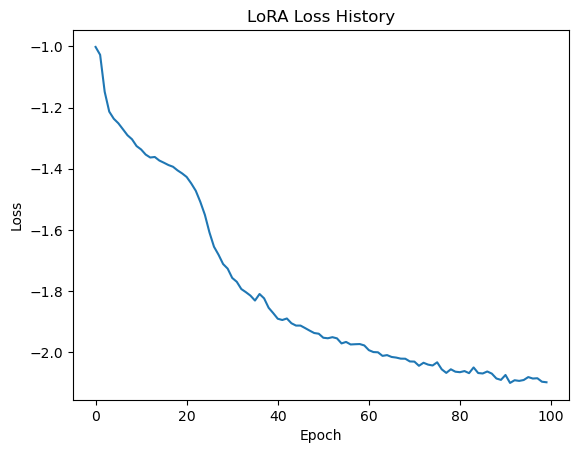

In [9]:
def train_koopman(model, dataloader, epochs=100, lr=1e-3, nesting='jnt'):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # 初始化 Loss，注意 n_modes 要和模型的一致
    criterion = LoRALoss(nesting=nesting, n_modes=model.n_modes).to(device)
    
    model.to(device)
    loss_history = []
    
    print(f"Starting training with nesting={nesting}...")
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            
            # 前向传播
            f, g = model(batch_x, batch_y)
            
            # 计算 Loss
            loss = criterion(f, g)
            
            # 反向传播
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
        avg_loss = epoch_loss / len(dataloader)
        loss_history.append(avg_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")
            
    return loss_history

# 配置参数
INPUT_DIM = 1   # Logistic Map 是 1D
HIDDEN_DIM = 64
N_MODES = 10    # 想要学习的前 k 个奇异函数 (包含常数项)
NESTING = 'jnt' # 推荐使用 'jnt' (Joint Nesting) 或 'seq'

# 初始化模型
model = KoopmanModel(INPUT_DIM, HIDDEN_DIM, N_MODES, center_data=True)

# 开始训练
history = train_koopman(model, dataloader, epochs=100, lr=1e-3, nesting=NESTING)

# 绘制 Loss
plt.plot(history)
plt.title("LoRA Loss History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_75721/2012142371.py:26: UserWarning: The operator 'aten::_linalg_eigh.eigenvalues' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  vals, vecs = torch.linalg.eigh(matrix)


Top singular values: [0.99999833 0.8496943  0.78927356 0.3371801  0.19223621]


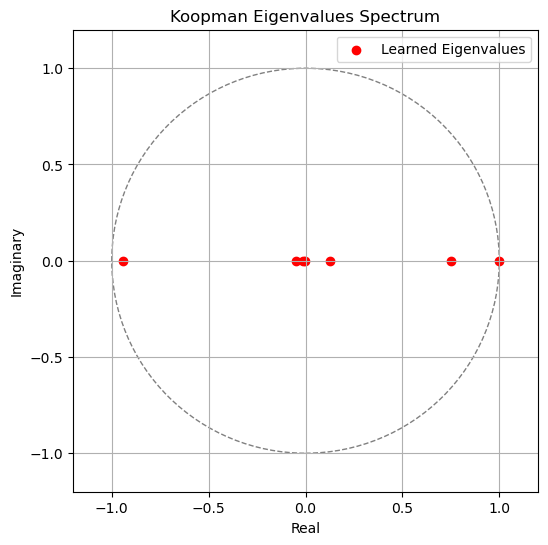

In [10]:
def compute_spectral_decomposition(model, x_data, y_data):
    """
    执行 CCA + LoRA 步骤来获取奇异值、特征值和 Koopman 矩阵。
    对应论文 Table 1 和 Eq (6), (7).
    """
    model.eval()
    with torch.no_grad():
        x_data = x_data.to(device)
        y_data = y_data.to(device)
        f, g = model(x_data, y_data)
        
    N = f.shape[0]
    
    # 1. 计算经验二阶矩矩阵
    # M_rho0[f] = 1/N * f.T @ f
    M_f = (f.T @ f) / N
    # M_rho1[g] = 1/N * g.T @ g
    M_g = (g.T @ g) / N
    # T[f, g] = 1/N * f.T @ g
    T_fg = (f.T @ g) / N
    
    # 2. CCA Step 1: Whitening (白化)
    # 计算 M^{-1/2}
    # 使用特征值分解来计算矩阵幂，增加数值稳定性
    def matrix_pow_inv(matrix, power=-0.5, epsilon=1e-6):
        vals, vecs = torch.linalg.eigh(matrix)
        vals = torch.clamp(vals, min=epsilon) # 避免除零
        return vecs @ torch.diag(vals.pow(power)) @ vecs.T

    M_f_inv_half = matrix_pow_inv(M_f)
    M_g_inv_half = matrix_pow_inv(M_g)
    
    # 3. CCA Step 2: SVD of the joint moment matrix
    # O = M_f^{-1/2} T_{fg} M_g^{-1/2}
    O = M_f_inv_half @ T_fg @ M_g_inv_half
    
    # 奇异值分解
    U, S, Vh = torch.linalg.svd(O, full_matrices=False)
    V = Vh.T
    
    # S 即为近似的 Koopman 奇异值 (Singular Values)
    print("Top singular values:", S[:5].cpu().numpy())
    
    # 4. 构建近似 Koopman 矩阵 (用于特征值分析和预测)
    # 论文 Section 3.2.1: K_approx = M_rho1[psi, phi] (Right) or similar structures
    # 但为了简单预测，我们通常计算投影后的矩阵 K_latent
    
    # 计算变换后的基函数 (Aligned singular functions)
    # phi(x) = Sigma^{1/2} U^T M_f^{-1/2} f(x)
    # psi(y) = Sigma^{1/2} V^T M_g^{-1/2} g(y)
    S_sqrt = torch.diag(S.pow(0.5))
    
    # 投影矩阵 P_f = M_f^{-1/2} U S^{1/2}
    P_f = M_f_inv_half @ U @ S_sqrt
    # 投影矩阵 P_g = M_g^{-1/2} V S^{1/2}
    P_g = M_g_inv_half @ V @ S_sqrt
    
    # 可以在隐空间进行线性预测
    # K_spectral 实际上是基于对角化假设，或者我们可以直接用 EDMD (Approach 2)
    # 为了遵循 Approach 2 (EDMD on learned basis g or f):
    # K_ols = (F.T F)^{-1} (F.T G) = M_f^{-1} T_{fg}
    K_ols = torch.linalg.pinv(M_f) @ T_fg
    
    # 特征值分解 K_ols
    eigvals, eigvecs = torch.linalg.eig(K_ols)
    
    return S, eigvals, K_ols

# 执行分析
singular_values, eigenvalues, K_matrix = compute_spectral_decomposition(model, test_x, test_y)

# 可视化特征值分布
plt.figure(figsize=(6, 6))
# 绘制单位圆
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_patch(circle)

evals_np = eigenvalues.cpu().numpy()
plt.scatter(evals_np.real, evals_np.imag, c='red', label='Learned Eigenvalues')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.title("Koopman Eigenvalues Spectrum")
plt.legend()
plt.grid(True)
plt.show()

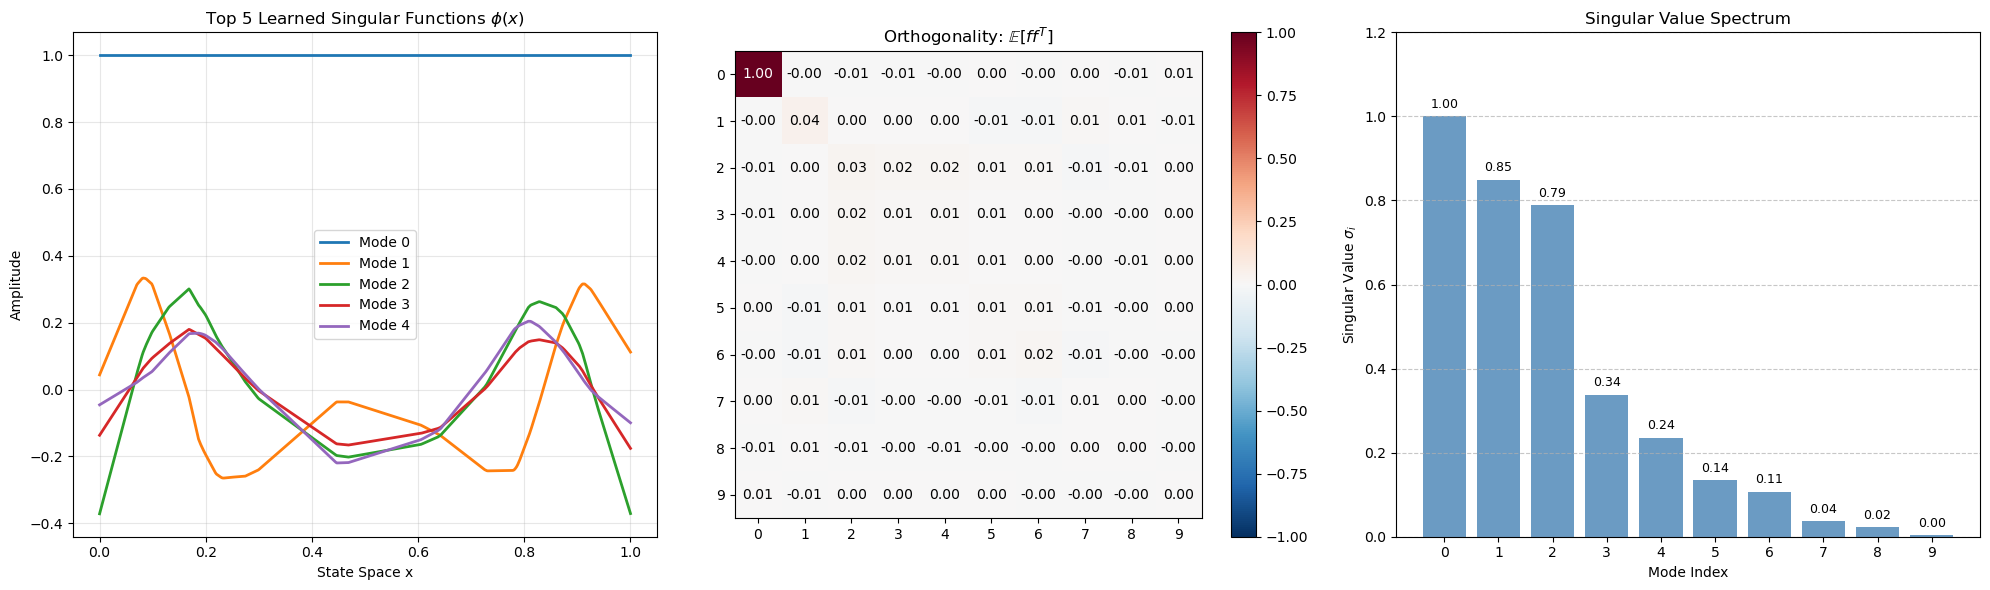

In [13]:
def visualize_results(model, test_x, test_y):
    model.eval()
    device = next(model.parameters()).device
    
    with torch.no_grad():
        # 1. 准备奇异函数绘图数据 (x 轴网格)
        x_grid = torch.linspace(0, 1, 500).view(-1, 1).to(device)
        f_grid, _ = model(x_grid, x_grid) 
        f_grid = f_grid.cpu().numpy()
        x_grid_np = x_grid.cpu().numpy()

        # 2. 计算奇异值和正交性 (使用测试集数据)
        f_test, g_test = model(test_x.to(device), test_y.to(device))
        N = f_test.shape[0]
        
        # 计算矩矩阵
        Mf = (f_test.T @ f_test) / N
        Mg = (g_test.T @ g_test) / N
        Tfg = (f_test.T @ g_test) / N
        
        # 提取奇异值 (SVD of whitened correlation matrix)
        def get_singular_values(Mf, Mg, Tfg):
            # 矩阵幂算子 M^{-1/2}
            def inv_sqrt(mat, eps=1e-8):
                vals, vecs = torch.linalg.eigh(mat)
                vals = torch.clamp(vals, min=eps)
                return vecs @ torch.diag(vals.pow(-0.5)) @ vecs.T
            
            Mf_inv_half = inv_sqrt(Mf)
            Mg_inv_half = inv_sqrt(Mg)
            # 核心算子 O = Mf^{-1/2} @ Tfg @ Mg^{-1/2}
            O = Mf_inv_half @ Tfg @ Mg_inv_half
            U, S, Vh = torch.linalg.svd(O)
            return S.cpu().numpy()

        singular_values = get_singular_values(Mf, Mg, Tfg)
        ortho_matrix = Mf.cpu().numpy()

    # --- 开始绘图 ---
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

    # 图 1：奇异函数 (从 index 0 开始，包含常数项)
    modes_to_plot = min(5, model.n_modes)
    for i in range(modes_to_plot):
        ax1.plot(x_grid_np, f_grid[:, i], label=f'Mode {i}', linewidth=2)
    ax1.set_title(f"Top {modes_to_plot} Learned Singular Functions $\phi(x)$")
    ax1.set_xlabel("State Space x")
    ax1.set_ylabel("Amplitude")
    ax1.legend()
    ax1.grid(alpha=0.3)

    # 图 2：正交性热力图
    im = ax2.imshow(ortho_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
    ax2.set_title("Orthogonality: $\mathbb{E}[f f^T]$")
    plt.colorbar(im, ax=ax2)
    ax2.set_xticks(range(model.n_modes))
    ax2.set_yticks(range(model.n_modes))
    for i in range(model.n_modes):
        for j in range(model.n_modes):
            ax2.text(j, i, f'{ortho_matrix[i, j]:.2f}', ha="center", va="center", 
                     color="white" if abs(ortho_matrix[i, j]) > 0.5 else "black")

    # 图 3：奇异值分布 (柱状图)
    ax3.bar(range(len(singular_values)), singular_values, color='steelblue', alpha=0.8)
    ax3.set_title("Singular Value Spectrum")
    ax3.set_xlabel("Mode Index")
    ax3.set_ylabel("Singular Value $\sigma_i$")
    ax3.set_xticks(range(len(singular_values)))
    # 在柱状图上方标出数值
    for i, v in enumerate(singular_values):
        ax3.text(i, v + 0.02, f'{v:.2f}', ha='center', fontsize=9)
    ax3.set_ylim(0, 1.2)
    ax3.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# 注意：调用时需要传入 test_x 和 test_y
visualize_results(model, test_x, test_y)